In [ ]:
from aeon.datasets.tsc_datasets import univariate # lista de datasets de séries temporais que serão investigados
from aeon.datasets import load_classification # biblioteca para o carregamento dos datasets, sem a necessidade de download de arquivos externos

from aeon.classification.convolution_based import RocketClassifier # importação do classificador Rocket (convolution-based)
from aeon.classification.feature_based import Catch22Classifier # importação do classificador baseado nas features catch-22 (feature-based)
from sklearn.metrics import accuracy_score # importação da biblioteca para medir a taxa de acerto do classificador

import time # biblioteca utilizada para medir o tempo de treinamento/teste do modelo
import numpy as np # biblioteca para manipulação dos arrays/matrizes
import matplotlib.pyplot as plt # biblioteca para visualizar as séries temporais

In [4]:
print(f"Lista com o nome dos {len(univariate)} datasets de benchmarking: \n{univariate}")

Lista com o nome dos 128 datasets de benchmarking: 
['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate'

In [ ]:
# Lista de datasets com alta dimensionalidade (mais de 1000 pontos por série temporal)
high_dim_datasets = [
  'ACSF1',
  'CinCECGTorso',
  'EOGHorizontalSignal',
  'EOGVerticalSignal',
  'EthanolLevel',
  'HandOutlines',
  'Haptics',
  'HouseTwenty',
  'InlineSkate',
  'Mallat',
  'MixedShapesRegularTrain',
  'MixedShapesSmallTrain',
  'Phoneme',
  'PigAirwayPressure',
  'PigArtPressure',
  'PigCVP',
  'Rock',
  'SemgHandGenderCh2',
  'SemgHandMovementCh2',
  'SemgHandSubjectCh2',
  'StarLightCurves'
]

In [20]:
# Filtra a lista de univariate datasets para manter apenas os de alta dimensionalidade
univariate_larger = [ds for ds in univariate if ds in high_dim_datasets]

print(f"Foram selecionados {len(univariate_larger)} de {len(univariate)} datasets, sendo eles: \n{univariate_larger}")

Foram selecionados 21 de 128 datasets, sendo eles: 
['ACSF1', 'CinCECGTorso', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'HandOutlines', 'Haptics', 'HouseTwenty', 'InlineSkate', 'Mallat', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain', 'Phoneme', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Rock', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'StarLightCurves']


In [28]:
# Carrega um dataset aleatório para testes
test_dataset = univariate[59]
X_train, y_train = load_classification(test_dataset, split="train")
X_test, y_test = load_classification(test_dataset, split="test")

print(f"O dataset {test_dataset} possui {X_train.shape[0]} exemplos de treino e {X_test.shape[0]} exemplos de teste")
print(f"Cada exemplo do dataset contém {X_train.shape[2]} observações")
print(f"O dataset possui as classes: {np.unique(y_train)}")

X_train.shape

O dataset HouseTwenty possui 40 exemplos de treino e 119 exemplos de teste
Cada exemplo do dataset contém 2000 observações
O dataset possui as classes: ['1' '2']


(40, 1, 2000)

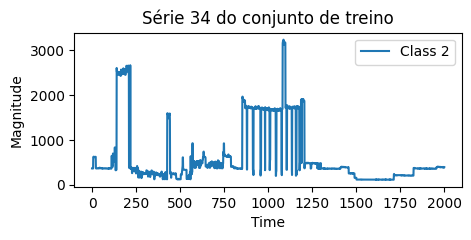

In [36]:
# Seleciona um instância qualquer desse dataset de teste
idx = 34
test_instance = X_train[idx, 0]

plt.figure(figsize=(5,2))
plt.title(f"Série {idx} do conjunto de treino")
plt.plot(test_instance, label=f'Class {y_train[idx]}')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()

In [88]:
# Define uma lista de funções de agregação que serão testadas
aggregations = {
    'average': np.mean,
    'mean': np.mean,
    'median': np.median,
    'max': np.max,
    'min': np.min,
    'sum': np.sum,
    'variance': np.var,
    'std': np.std,
    'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
    'first': lambda x: x[0],
    'central': lambda x: x[len(x)//2],
    'last': lambda x: x[-1],
    'max-min': lambda x: np.max(x) - np.min(x),
    'avg-max': lambda x: np.abs((np.mean(x) - np.max(x))),
    'avg-min': lambda x: np.abs((np.mean(x) - np.min(x))),
    'random': lambda x: np.random.choice(x)
}

In [89]:
# Algoritimo usado para reduzir a dimensionalidade das séries temporais usando PAA (Piecewise Aggregate Approximation)
# com adaptacão para permitir diferentes funções de agregação
def PAA(s, w, agg='mean'):
    # Valida se a função de agregação recebida como argumento pertence ao dicionário de funções suportadas.
    if agg not in aggregations:
        raise ValueError(f"Função de agregação '{agg}' é inválida ou não suportada.")

    # Salva o tamanho da série temporal original.
    n = len(s)

    # Converte a série temporal em um array numpy para melhor performance.
    s = np.array(s)

    # Cria n valores uniformemente espaçados entre 0 (inclusivo) e w (exclusivo).
    # Cada ponto da série é mapeado para um valor entre 0 e w.
    # Por exemplo: n=9 e w=3 será [0,0,0,1,1,1,3,3,3]
    idx = np.floor(np.linspace(0, w, n, endpoint=False)).astype(int)

    # Agrega os pontos da série temporal usando a função de agregação escolhida.
    res = [aggregations[agg](s[idx == i]) for i in range(w)]

    return np.array(res)

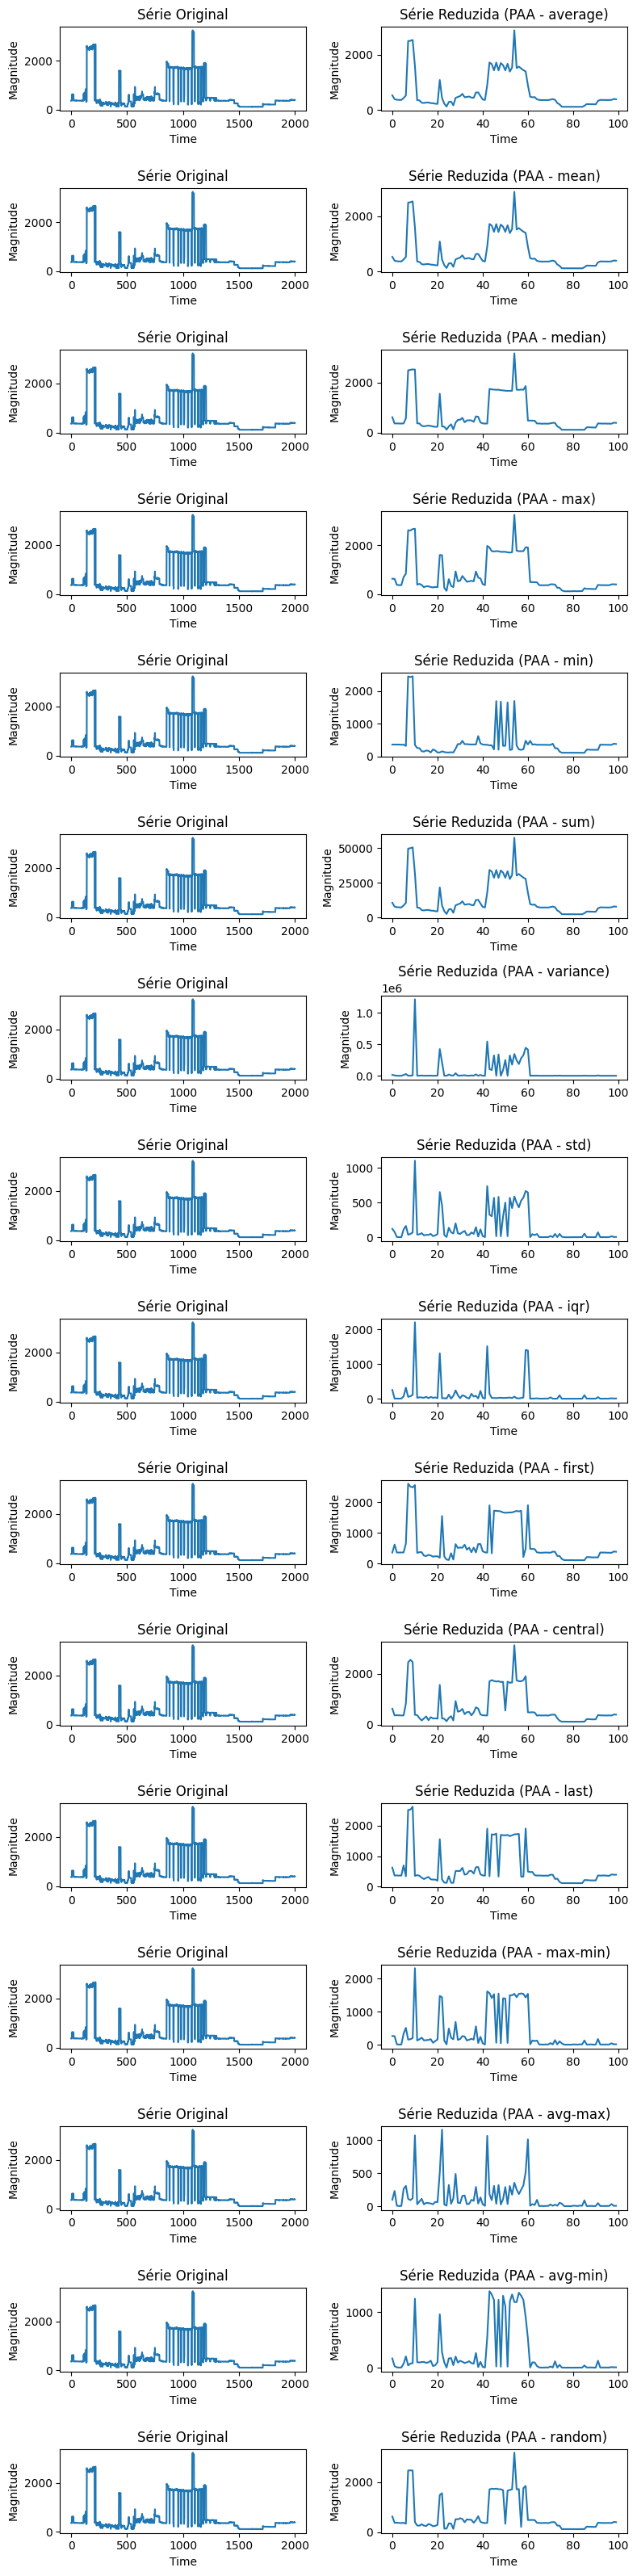

In [90]:
# Testa o algoritmo PAA na nossa instância de teste usando todos as funções de agregação suportadas
# Inicia criando uma lista com os nomes dos métodos de agregaçao suportados
agg_methods = list(aggregations.keys())

# Define o tamanho que a série reduzida deve ter
reduce_size = 100

# Cria a estrutura de plots com 2 colunas (original e reduzida) e uma linha para cada método de agregação
fig, axes = plt.subplots(len(agg_methods), 2, figsize=(8, 2*len(agg_methods)))

# Iterar sobre os métodos de agregação e plota os resultados
for i, method in enumerate(agg_methods):
    reduced = PAA(test_instance, reduce_size, agg=method)

    # Plot da intancia de teste original.
    # Foi optado por plotar a série original em cada linha para facilitar a comparação visual.
    axes[i, 0].plot(test_instance)
    axes[i, 0].set_title('Série Original')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Magnitude')

    # Plot da série reduzida
    axes[i, 1].plot(reduced)
    axes[i, 1].set_title(f'Série Reduzida (PAA - {method})')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()